# Part-1: M√¥ t·∫£ - ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu


H·ªç t√™n: Nguy·ªÖn Ph√∫ Trung Anh

MSSV: 18120276

- T·∫≠p d·ªØ li·ªáu stopwords: s·ª≠ d·ª•ng theo g·ª£i √Ω trong PDF.
- Tool tokenizer: s·ª≠ d·ª•ng VnCoreNLP theo g·ª£i √Ω trong PDF.

# Part-2: EDA - M√¥ h√¨nh h·ªçc m√°y LSTM
H·ªç t√™n: Ph·∫°m Tu·∫•n Anh
MSSV: 18120279

- EDA
- S·ª≠ d·ª•ng m√¥ h√¨nh h·ªçc m√°y LSTM ph·ªï bi·∫øn trong NLP.

# Part-3: M√¥ h√¨nh h·ªçc m√°y Logistic Regression - Deploy
H·ªç t√™n: ƒêinh Nguy√™n Kh√°nh
MSSV: 19120087

- S·ª≠ d·ª•ng m√¥ h√¨nh h·ªçc m√°y Logistic Regression
- Code app streamlit.py

### Link deploy: https://share.streamlit.io/beiryu/fake_new/main/fake_new_detection.py

---

## Import

In [205]:
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from keras.layers import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from wordcloud import WordCloud
import re
import numpy as np
import matplotlib.pyplot as plt
import unicodedata as ud
import pandas as pd
from vncorenlp import VnCoreNLP
annotator = VnCoreNLP(address="http://127.0.0.1", port=9000)


# pd.set_option('display.max_colwidth', None)

---

## M√¥ t·∫£ d·ªØ li·ªáu
### Xem d·ªØ li·ªáu

In [206]:
data_df = pd.read_csv('vn_news_223_tdlfr.csv')
data_df.head()

text               domain  \
0  Th·ªß t∆∞·ªõng Abe c√∫i ƒë·∫ßu xin l·ªói v√¨ h√†nh ƒë·ªông phi...         binhluan.biz   
1  Th·ªß t∆∞·ªõng Nh·∫≠t c√∫i ƒë·∫ßu xin l·ªói v√¨ tinh th·∫ßn ph...         www.ipick.vn   
2  Cho√°ng! C∆° tr∆∞·ªüng ƒëeo khƒÉn qu√†ng qu·∫©y banh n√≥c...       tintucqpvn.net   
3  Ch∆∞a bao gi·ªù nh·∫°c Kpop l·∫°i d·ªÖ h√°t ƒë·∫øn th·∫ø!!!\n...       tintucqpvn.net   
4  ƒê·∫°i h·ªçc Hutech s·∫Ω √°p d·ª•ng c·∫£i c√°ch "Ti·∫øq Vi·ªát"...  www.gioitreviet.net   

   label  
0      1  
1      1  
2      1  
3      1  
4      1

### ƒê·∫øm s·ªë l∆∞·ª£ng d√≤ng d·ªØ li·ªáu

In [207]:
data_df.shape[0]

223

### M·ªói d√≤ng c√≥ √Ω nghƒ©a g√¨? C√≥ v·∫•n ƒë·ªÅ c√°c d√≤ng c√≥ √Ω nghƒ©a kh√°c nhau kh√¥ng?

- Khi quan s√°t d·ªØ li·ªáu, ta th·∫•y m·ªói d√≤ng g·ªìm th√¥ng tin v·ªÅ m·ªôt tin t·ª©c (c·ªôt text), domain name c·ªßa trang ƒëƒÉng tin t·ª©c (c·ªôt domain) v√† ch·ªâ s·ªë 1(gi·∫£) hay 0(th·∫≠t) v·ªÅ t√≠nh ch√≠nh x√°c c·ªßa tin t·ª©c ƒë√≥.
- Kh√¥ng c√≥ v·∫•n ƒë·ªÅ g√¨ v·ªÅ vi·ªác c√°c d√≤ng c√≥ √Ω nghƒ©a kh√°c nhau.
- Trong tin t·ª©c c√≥ th·ªÉ c√≥ nhi·ªÅu c√¢u ho·∫∑c c√°c k√≠ t·ª± ƒë·∫∑c bi·ªát ho·∫∑c c√°c ƒë∆∞·ªùng link.

### D·ªØ li·ªáu c√≥ c√°c d√≤ng b·ªã l·∫∑p kh√¥ng?

In [208]:
data_df.index.duplicated().sum()

0

### Ki·ªÉm tra ki·ªÉu c·ªßa d·ªØ li·ªáu

In [209]:
data_df.dtypes

text      object
domain    object
label      int64
dtype: object

### Ki·ªÉm tra xem c√≥ c·ªôt n√†o c√≥ gi√° tr·ªã thi·∫øu kh√¥ng


In [210]:
data_df.isna().sum()

text      0
domain    0
label     0
dtype: int64

## Thi·∫øt k·∫ø c√°c h√†m ti·ªÅn x·ª≠ l√Ω
### Chu·∫©n ho√° b·∫£ng m√£ Unicode
Ta s·∫Ω vi·∫øt h√†m chuy·ªÉn sang s·ª≠ d·ª•ng b·ªô Unicode d·ª±ng s·∫µn. 

In [211]:
def NFC_normalize(text):
    return ud.normalize('NFC',text)

### Lo·∫°i b·ªè k√≠ t·ª± ƒë·∫∑c bi·ªát
- ƒê·∫ßu ti√™n, ta thay th·∫ø c√°c d·∫•u xu·ªëng d√≤ng v√† c√°c d·∫•u k·∫øt th√∫c c√¢u (d·∫•u ?, d·∫•u !, d·∫•u ;) b·∫±ng d·∫•u ch·∫•m v√† 1 kho·∫£ng tr·∫Øng. 
- C√°c k√≠ t·ª± c√≥ th·ªÉ ch·ªâ ng√†y th√°ng, t·ªâ s·ªë nh∆∞ '/' hay '-' s·∫Ω ƒë∆∞·ª£c gi·ªØ nguy√™n.
- C√°c k√≠ t·ª± ƒë·∫∑c bi·ªát c√≤n l·∫°i ngo√†i d·∫•u ch·∫•m s·∫Ω ƒë∆∞·ª£c thay b·∫±ng kho·∫£ng tr·∫Øng.

In [212]:
special_char = '@#$^&*()[]{}:,<>\|`~=_+-'


def remove_noice(text):
    result = ""
    for c in text:
        if ((c == '\n') or (c == '?') or (c == '!') or (c == ';')):
            result += '. '
        else:
            i = special_char.find(c)
            if (i != -1):
                result += ' '
            else:
                result += c
    return result

Sau khi ƒë√£ t√°ch token ƒë√∫ng, ta th·ª±c hi·ªán x√≥a c√°c d·∫•u ch·∫•m '.', '..' ho·∫∑c '...' ·ªü cu·ªëi c√¢u trong list v·ª´a thu ƒë∆∞·ª£c. 

In [213]:
def remove_dot(list):
    for sentence in list[:]:
        for word in sentence:
            word = word.replace('.', '')
    return list

### Lowercase c√°c token
Ta th·ª±c hi·ªán lowercase sau khi ƒë√£ t√°ch token. S·ªü dƒ© kh√¥ng lowercase tr∆∞·ªõc khi t√°ch token l√† ƒë·ªÉ tool t√°ch token t√°ch ƒë∆∞·ª£c t√™n ri√™ng ƒë√∫ng.

In [214]:
def lower_case(list):
    for sentence in list:
        for i in range(len(sentence)):
            sentence[i] = sentence[i].lower()
    return list

### Lo·∫°i b·ªè stop word
Ta ƒë·ªçc v√†o c√°c stopword t·ª´ file vietnamese-stopwords.txt. Ti·∫øp ƒë√≥ s·∫Ω x√¢y d·ª±ng 1 list g·ªìm c√°c stopwords c√≥ c·∫•u tr√∫c gi·ªëng 1 token khi t√°ch c√°c tin t·ª©c (ƒë·ªÉ d·ªÖ so s√°nh).

In [215]:
stopwords = []
f = open('vietnamese-stopwords.txt', encoding="utf8")
lines = f.readlines()
for l in lines:
    # x√≥a k√≠ t·ª± xu·ªëng d√≤ng
    l = l.rstrip("\n")
    # chu·∫©n h√≥a
    l = NFC_normalize(l)
    # t·∫°o token stopword
    string = ""
    for c in l:
        if (c != ' '):
            string += c
        else:
            string += '_'
    stopwords.append(string)
# xem list stopwords:
stopwords

['a_l√¥',
 'a_ha',
 'ai',
 'ai_ai',
 'ai_n·∫•y',
 'ai_ƒë√≥',
 'al√¥',
 'amen',
 'anh',
 'anh_·∫•y',
 'ba',
 'ba_ba',
 'ba_b·∫£n',
 'ba_c√πng',
 'ba_h·ªç',
 'ba_ng√†y',
 'ba_ng√¥i',
 'ba_tƒÉng',
 'bao_gi·ªù',
 'bao_l√¢u',
 'bao_nhi√™u',
 'bao_n·∫£',
 'bay_bi·∫øn',
 'bi·∫øt',
 'bi·∫øt_bao',
 'bi·∫øt_bao_nhi√™u',
 'bi·∫øt_ch·∫Øc',
 'bi·∫øt_ch·ª´ng_n√†o',
 'bi·∫øt_m√¨nh',
 'bi·∫øt_m·∫•y',
 'bi·∫øt_th·∫ø',
 'bi·∫øt_tr∆∞·ªõc',
 'bi·∫øt_vi·ªác',
 'bi·∫øt_ƒë√¢u',
 'bi·∫øt_ƒë√¢u_ch·ª´ng',
 'bi·∫øt_ƒë√¢u_ƒë·∫•y',
 'bi·∫øt_ƒë∆∞·ª£c',
 'bu·ªïi',
 'bu·ªïi_l√†m',
 'bu·ªïi_m·ªõi',
 'bu·ªïi_ng√†y',
 'bu·ªïi_s·ªõm',
 'b√†',
 'b√†_·∫•y',
 'b√†i',
 'b√†i_b√°c',
 'b√†i_b·ªè',
 'b√†i_c√°i',
 'b√°c',
 'b√°n',
 'b√°n_c·∫•p',
 'b√°n_d·∫°',
 'b√°n_th·∫ø',
 'b√¢y_b·∫©y',
 'b√¢y_ch·ª´',
 'b√¢y_gi·ªù',
 'b√¢y_nhi√™u',
 'b√®n',
 'b√©ng',
 'b√™n',
 'b√™n_b·ªã',
 'b√™n_c√≥',
 'b√™n_c·∫°nh',
 'b√¥ng',
 'b∆∞·ªõc',
 'b∆∞·ªõc_kh·ªèi',
 'b∆∞·ªõc_t·ªõi',
 'b∆∞·ªõc_ƒëi',
 'b·∫°n',
 'b·∫£n',
 'b·∫£n_b·ªô',
 'b·∫£n_ri√™ng',


Ki·ªÉm tra xem c√≥ ƒë·ªß l∆∞·ª£ng stopword so v·ªõi trong file txt kh√¥ng (1942 d√≤ng)

In [216]:
assert (len(stopwords)==1942)

Sau ƒë√≥ ta vi·∫øt h√†m lo·∫°i b·ªè nh·ªØng token l√† stopword ra kh·ªèi list token ƒë√£ t√°ch ·ªü tr∆∞·ªõc:

In [217]:
def remove_stopwords(row, stopwords):
    for sentence in row[:]:
        for token in sentence[:]:
            if (token in stopwords):
                sentence.remove(token)
    return row

In [218]:
def http_remove(txt):
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?¬´¬ª‚Äú‚Äù‚Äò‚Äô]))''', '', txt)

---

In [219]:
# test th·ª≠ v·ªõi 1 chu·ªói text b·∫•t k√¨
text = 'Phi√™n b·∫£n 3.5... C√°c "nh√¢n s·ª±" Jupyter? B·∫°n c·∫ßn g√¨\ v√†o 3/5? Bao gi·ªù~ tr·ªü v·ªÅ? B·∫•t k·ªÉ l√† ƒë√∫ng ƒëi chƒÉng n·ªØa! Bi·∫øt ƒë√¢u ch·ª´ng https://giadinhvietnam.com/xot-xa-hinh-anh-thay-tro-loi-bun-bang-rung-den-truong-o-nghe-an-d132732.html'
print("Before processing: ")
print(text)
text = http_remove(text)
text = NFC_normalize(text)
text = remove_noice(text)
text = annotator.tokenize(text)
text = remove_dot(text)
text = lower_case(text)
text = remove_stopwords(text, stopwords)
print("After processing:")
print(text)

Before processing: 
Phi√™n b·∫£n 3.5... C√°c "nh√¢n s·ª±" Jupyter? B·∫°n c·∫ßn g√¨\ v√†o 3/5? Bao gi·ªù~ tr·ªü v·ªÅ? B·∫•t k·ªÉ l√† ƒë√∫ng ƒëi chƒÉng n·ªØa! Bi·∫øt ƒë√¢u ch·ª´ng https://giadinhvietnam.com/xot-xa-hinh-anh-thay-tro-loi-bun-bang-rung-den-truong-o-nghe-an-d132732.html
After processing:
[['phi√™n_b·∫£n', '3.5', '...'], ['"', 'nh√¢n_s·ª±', '"', 'jupyter', '.'], ['3/5', '.'], ['tr·ªü', '.'], ['ƒëi_chƒÉng_n·ªØa', '.'], []]


---

## Th·ª±c hi·ªán t·∫•t c·∫£ c√°c b∆∞·ªõc ti·ªÅn x·ª≠ l√Ω

In [220]:
def pre_process(row):
    # l·∫•y ra text
    text = row['text']
    # Lo·∫°i b·ªè link:
    text = http_remove(text)
    # chu·∫©n h√≥a unicode d·ª±ng s·∫µn
    text = NFC_normalize(text)
    # lo·∫°i b·ªè k√≠ t·ª± ƒë·∫∑c bi·ªát l·∫ßn 1
    text = remove_noice(text)
    # t√°ch token (th·ª±c hi·ªán t√°ch token sau b∆∞·ªõc lo·∫°i noice l·∫ßn 1 ƒë·ªÉ t√°ch ƒë√∫ng token)
    text = annotator.tokenize(text)
    # lo·∫°i b·ªè token . cu·ªëi c√¢u v√¨ kh√¥ng c√≤n t√°c d·ª•ng
    text = remove_dot(text)
    # lowercase
    text = lower_case(text)
    # lo·∫°i b·ªè stopwords
    text = remove_stopwords(text, stopwords)
    # lo·∫°i b·ªè array tr·ªëng
    text = [x for x in text if x != []]

    return text

In [221]:
#s·ª≠ d·ª•ng h√†m pre-process v√†o dataframe
data_df['tokens'] = data_df.apply(pre_process,axis=1)

In [222]:
def clean_joined(x):
    bag = []
    for line in x:
        for word in line:
            if (word not in bag) and (word.isdigit() == False):
                bag.append(word)
            else:
                continue
    return bag

In [223]:
data_df['clean_tokens'] = data_df['tokens'].apply(clean_joined)

In [224]:
# s·ªë l∆∞·ª£ng token l·ªõn nh·∫•t l√†?
max_tokens = data_df['clean_tokens'].max()
len(max_tokens)

104

In [225]:
data_df

text               domain  \
0    Th·ªß t∆∞·ªõng Abe c√∫i ƒë·∫ßu xin l·ªói v√¨ h√†nh ƒë·ªông phi...         binhluan.biz   
1    Th·ªß t∆∞·ªõng Nh·∫≠t c√∫i ƒë·∫ßu xin l·ªói v√¨ tinh th·∫ßn ph...         www.ipick.vn   
2    Cho√°ng! C∆° tr∆∞·ªüng ƒëeo khƒÉn qu√†ng qu·∫©y banh n√≥c...       tintucqpvn.net   
3    Ch∆∞a bao gi·ªù nh·∫°c Kpop l·∫°i d·ªÖ h√°t ƒë·∫øn th·∫ø!!!\n...       tintucqpvn.net   
4    ƒê·∫°i h·ªçc Hutech s·∫Ω √°p d·ª•ng c·∫£i c√°ch "Ti·∫øq Vi·ªát"...  www.gioitreviet.net   
..                                                 ...                  ...   
218  ‚ÄúSi√™u m√°y bay‚Äù A350 s·∫Ω ch·ªü CƒêV Vi·ªát Nam ƒëi Mal...        dantri.com.vn   
219  Th∆∞·ªüng 20.000 USD cho ƒë·ªôi tuy·ªÉn c·ªù vua Vi·ªát Na...        dantri.com.vn   
220  Tr∆∞·ªùng S∆°n gi√†nh HCV t·∫°i gi·∫£i c·ªù vua ƒë·ªìng ƒë·ªôi ...        dantri.com.vn   
221  Chuy·ªán v·ªÅ ch√†ng sinh vi√™n Lu·∫≠t - Ki·ªán t∆∞·ªõng L√™...        dantri.com.vn   
222  Ti·ªÅn ƒë·∫°o Malaysia: ‚ÄúT√¥i ƒë√£ c√≥ c√°ch v∆∞·ª£t qua h√†...        dantri.com.vn   

     label                                             tokens  \
0        1  [[th·ªß_t∆∞·ªõng, abe, c√∫i, ƒë·∫ßu, xin_l·ªói, h√†nh_ƒë·ªông...   
1        1  [[th·ªß_t∆∞·ªõng, nh·∫≠t, c√∫i, ƒë·∫ßu, xin_l·ªói, tinh_th·∫ß...   
2        1  [[cho√°ng, .], [c∆°_tr∆∞·ªüng, ƒëeo, khƒÉn_qu√†ng, qu·∫©...   
3        1  [[nh·∫°c, kpop, h√°t, .], [.], [.], [.], [gi√°o_s∆∞...   
4        1  [[ƒë·∫°i_h·ªçc, hutech, √°p_d·ª•ng, c·∫£i_c√°ch, ", ti·∫øq_...   
..     ...                                                ...   
218      0  [[‚Äú, si√™u, m√°y_bay, ‚Äù, a350, ch·ªü, cƒëv, vi·ªát_na...   
219      0  [[th∆∞·ªüng, 20.000, usd, ƒë·ªôi_tuy·ªÉn, c·ªù_vua, vi·ªát...   
220      0  [[tr∆∞·ªùng_s∆°n, gi√†nh, hcv, gi·∫£i, c·ªù_vua, ƒë·ªìng_ƒë...   
221      0  [[ch√†ng, sinh_vi√™n, lu·∫≠t, ki·ªán_t∆∞·ªõng, l√™_tu·∫•n_...   
222      0  [[ti·ªÅn_ƒë·∫°o, malaysia, ‚Äú, h√†ng, th·ªß, ƒë·ªôi_tuy·ªÉn,...   

                                          clean_tokens  
0    [th·ªß_t∆∞·ªõng, abe, c√∫i, ƒë·∫ßu, xin_l·ªói, h√†nh_ƒë·ªông,...  
1    [th·ªß_t∆∞·ªõng, nh·∫≠t, c√∫i, ƒë·∫ßu, xin_l·ªói, tinh_th·∫ßn...  
2    [cho√°ng, ., c∆°_tr∆∞·ªüng, ƒëeo, khƒÉn_qu√†ng, qu·∫©y, ...  
3    [nh·∫°c, kpop, h√°t, ., gi√°o_s∆∞, nguy·ªÖn_l√¢n_d≈©ng,...  
4    [ƒë·∫°i_h·ªçc, hutech, √°p_d·ª•ng, c·∫£i_c√°ch, ", ti·∫øq_v...  
..                                                 ...  
218  [‚Äú, si√™u, m√°y_bay, ‚Äù, a350, ch·ªü, cƒëv, vi·ªát_nam...  
219  [th∆∞·ªüng, 20.000, usd, ƒë·ªôi_tuy·ªÉn, c·ªù_vua, vi·ªát_...  
220  [tr∆∞·ªùng_s∆°n, gi√†nh, hcv, gi·∫£i, c·ªù_vua, ƒë·ªìng_ƒë·ªô...  
221  [ch√†ng, sinh_vi√™n, lu·∫≠t, ki·ªán_t∆∞·ªõng, l√™_tu·∫•n_m...  
222  [ti·ªÅn_ƒë·∫°o, malaysia, ‚Äú, h√†ng, th·ªß, ƒë·ªôi_tuy·ªÉn, ...  

[223 rows x 5 columns]

Sau khi ti·ªÅn x·ª≠ l√Ω, trong dataframe c√≥ th√™m 1 c·ªôt tokens.
- Mi√™u t·∫£ c·ªôt tokens:
[ [c√°c token c·ªßa c√¢u vƒÉn 1], [c√°c token c·ªßa c√¢u vƒÉn 2], [c√°c token c·ªßa c√¢u vƒÉn 3],...]

---

# Part 2: EDA v√† h·ªçc m√°y

## Kh√°m ph√° d·ªØ li·ªáu.

### c·ªôt label k·∫øt qu·∫£

In [226]:
# th·ªëng k√™ c√°c c·ªôt
data_df['word_count'] = data_df['text'].apply(lambda x: len(x.split()))

In [227]:
list_of_words = []
for i in data_df['clean_tokens']:
    list_of_words.append(i)

In [228]:
list_of_words

[['th·ªß_t∆∞·ªõng',
  'abe',
  'c√∫i',
  'ƒë·∫ßu',
  'xin_l·ªói',
  'h√†nh_ƒë·ªông',
  'phi',
  'th·ªÉ_thao',
  'tuy·ªÉn',
  'nh·∫≠t',
  '.',
  'sankei_sports',
  'nh·∫≠t_b·∫£n',
  'shinzo_abe',
  'c√¥ng_khai',
  'g·ª≠i',
  'ho√†ng',
  'to√†n_b·ªô',
  'ng∆∞·ªùi_d√¢n',
  'tinh_th·∫ßn',
  'thi_ƒë·∫•u',
  'ƒë·ªôi_tuy·ªÉn',
  'world_cup',
  '..',
  't·ªëi_qua',
  'l∆∞·ª£t',
  'tr·∫≠n',
  'v√≤ng',
  'b·∫£ng',
  'ch·ªâ_s·ªë',
  'ph·ª•',
  'senegal',
  'ƒë·ªôi',
  'thua',
  'colombia',
  'fair',
  'play',
  'th·∫ª',
  'ph·∫°t',
  '‚Äú',
  'v√µ_sƒ©_ƒë·∫°o',
  'samurai',
  'th∆∞·ª£ng_v√µ',
  'ch·ªâ_tr√≠ch',
  'b·∫•t_b√¨nh',
  'to√†n',
  'd√¢n',
  'h√¨nh_·∫£nh',
  'ki√™n_c∆∞·ªùng',
  'ƒë·∫•u_tr∆∞·ªùng',
  'qu·ªëc_t·∫ø',
  'ƒë·ª©ng',
  'th√†nh_th·∫≠t',
  'tr√°ch_nhi·ªám',
  's√¢u_s·∫Øc',
  'nh√¢n_d√¢n',
  '‚Äù',
  'n·ªïi_ti·∫øng',
  'ch·∫•t',
  '√°o',
  'xanh',
  'm·ªánh_danh',
  'd·ªØ_d·ªôi',
  'h√¢m_m·ªô',
  'b√≥ng_ƒë√°',
  'l·ªëi',
  'b√≥ng',
  'ti√™u_c·ª±c',
  'c·ªë_t√¨nh',
  'c√¢u',
  'ƒë·ªÉ

In [229]:
# s·ªë l∆∞·ª£ng t·ª´ ƒë·ªôc nh·∫•t(unique)
total_words = []
for line in list_of_words:
    for word in line:
        if word not in total_words:
            total_words.append(word)
        else:
            continue

In [230]:
total_words

['th·ªß_t∆∞·ªõng',
 'abe',
 'c√∫i',
 'ƒë·∫ßu',
 'xin_l·ªói',
 'h√†nh_ƒë·ªông',
 'phi',
 'th·ªÉ_thao',
 'tuy·ªÉn',
 'nh·∫≠t',
 '.',
 'sankei_sports',
 'nh·∫≠t_b·∫£n',
 'shinzo_abe',
 'c√¥ng_khai',
 'g·ª≠i',
 'ho√†ng',
 'to√†n_b·ªô',
 'ng∆∞·ªùi_d√¢n',
 'tinh_th·∫ßn',
 'thi_ƒë·∫•u',
 'ƒë·ªôi_tuy·ªÉn',
 'world_cup',
 '..',
 't·ªëi_qua',
 'l∆∞·ª£t',
 'tr·∫≠n',
 'v√≤ng',
 'b·∫£ng',
 'ch·ªâ_s·ªë',
 'ph·ª•',
 'senegal',
 'ƒë·ªôi',
 'thua',
 'colombia',
 'fair',
 'play',
 'th·∫ª',
 'ph·∫°t',
 '‚Äú',
 'v√µ_sƒ©_ƒë·∫°o',
 'samurai',
 'th∆∞·ª£ng_v√µ',
 'ch·ªâ_tr√≠ch',
 'b·∫•t_b√¨nh',
 'to√†n',
 'd√¢n',
 'h√¨nh_·∫£nh',
 'ki√™n_c∆∞·ªùng',
 'ƒë·∫•u_tr∆∞·ªùng',
 'qu·ªëc_t·∫ø',
 'ƒë·ª©ng',
 'th√†nh_th·∫≠t',
 'tr√°ch_nhi·ªám',
 's√¢u_s·∫Øc',
 'nh√¢n_d√¢n',
 '‚Äù',
 'n·ªïi_ti·∫øng',
 'ch·∫•t',
 '√°o',
 'xanh',
 'm·ªánh_danh',
 'd·ªØ_d·ªôi',
 'h√¢m_m·ªô',
 'b√≥ng_ƒë√°',
 'l·ªëi',
 'b√≥ng',
 'ti√™u_c·ª±c',
 'c·ªë_t√¨nh',
 'c√¢u',
 'ƒë·ªÉ_d√†nh',
 'v√©',
 'ƒëi',
 'ti·∫øp',
 'ph√∫t',
 'ba_lan',
 'th·∫Øng',
 '

In [231]:
len(total_words)

8486

In [232]:
data_df['clean_joined'] = data_df['clean_tokens'].apply(lambda x: " ".join(x))

In [233]:
data_df['clean_joined']

0      th·ªß_t∆∞·ªõng abe c√∫i ƒë·∫ßu xin_l·ªói h√†nh_ƒë·ªông phi th...
1      th·ªß_t∆∞·ªõng nh·∫≠t c√∫i ƒë·∫ßu xin_l·ªói tinh_th·∫ßn phi t...
2      cho√°ng . c∆°_tr∆∞·ªüng ƒëeo khƒÉn_qu√†ng qu·∫©y banh s√¢...
3      nh·∫°c kpop h√°t . gi√°o_s∆∞ nguy·ªÖn_l√¢n_d≈©ng ‚Äò th√†n...
4      ƒë·∫°i_h·ªçc hutech √°p_d·ª•ng c·∫£i_c√°ch " ti·∫øq_vi·ªát nƒÉ...
                             ...                        
218    ‚Äú si√™u m√°y_bay ‚Äù a350 ch·ªü cƒëv vi·ªát_nam ƒëi mala...
219    th∆∞·ªüng 20.000 usd ƒë·ªôi_tuy·ªÉn c·ªù_vua vi·ªát_nam ol...
220    tr∆∞·ªùng_s∆°n gi√†nh hcv gi·∫£i c·ªù_vua ƒë·ªìng_ƒë·ªôi th·∫ø_...
221    ch√†ng sinh_vi√™n lu·∫≠t ki·ªán_t∆∞·ªõng l√™_tu·∫•n_minh ....
222    ti·ªÅn_ƒë·∫°o malaysia ‚Äú h√†ng th·ªß ƒë·ªôi_tuy·ªÉn vi·ªát_na...
Name: clean_joined, Length: 223, dtype: object

### C√°c token ph·ªï bi·∫øn

In [234]:
# Trung b√¨nh m·ªói text c√≥ bao nhi√™u t·ª´?
data_df['word_count'].mean()

564.713004484305

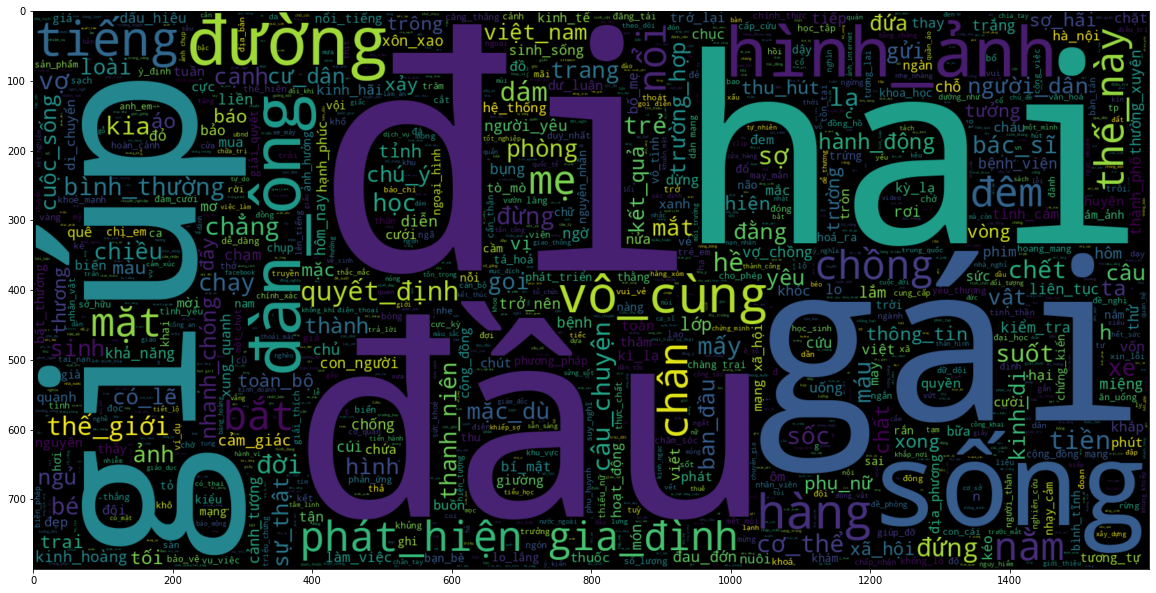

In [235]:
# token thu·ªôc label 1
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(data_df[data_df.label == 1].clean_joined))
plt.imshow(wc, interpolation='bilinear')

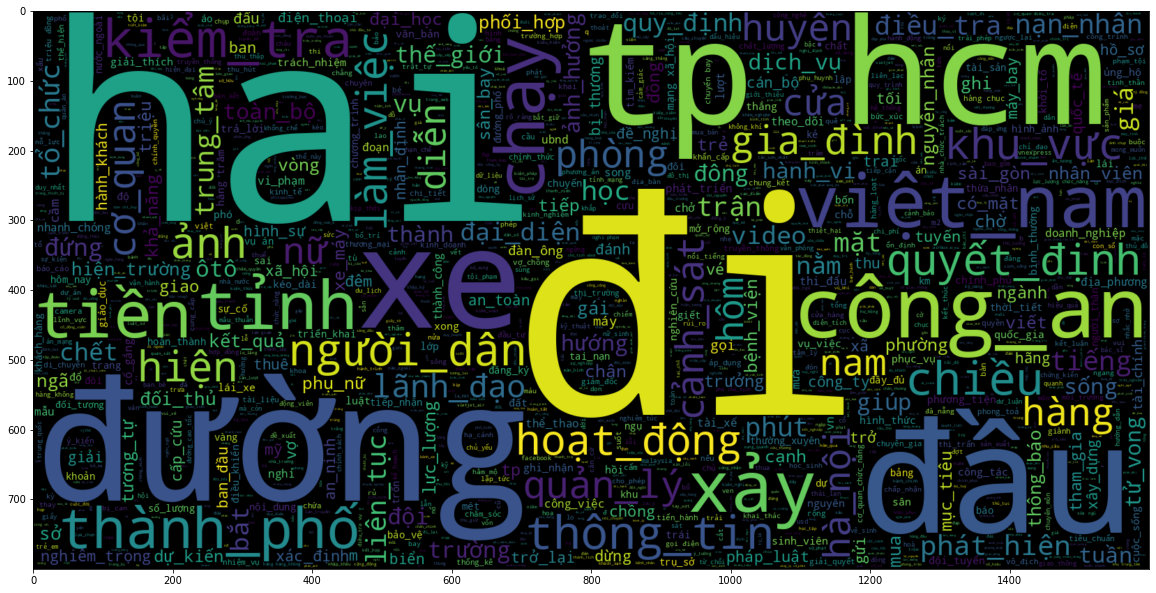

In [236]:
# token thu·ªôc label 0
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(data_df[data_df.label == 0].clean_joined))
plt.imshow(wc, interpolation='bilinear')

In [237]:
#  Text c√≥ nhi·ªÅu t·ª´ nh·∫•t g·ªìm bao nhi√™u t·ª´?
data_df['word_count'].max()

2331

In [238]:
# C·ªôt output c√≥ bao nhi√™u gi√° tr·ªã thi·∫øu?
data_df['label'].isna().sum()

0

0    55.156951
1    44.843049
Name: label, dtype: float64

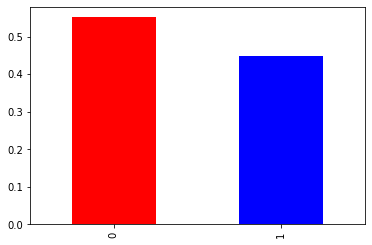

In [239]:
# T·ªâ l·ªá c√°c l·ªõp trong c·ªôt output?
data_df['label'].value_counts(normalize=True).plot(
    kind="bar", color=["red", "blue"])
data_df['label'].value_counts(normalize=True) * 100

TiÃâ l√™Ã£ gi∆∞ÃÉa caÃÅc l∆°ÃÅp cuÃÉng khaÃÅ c√¢n bƒÉÃÄng, 

### T√°ch d·ªØ li·ªáu

In [240]:
# T√°ch X v√† y
y_sr = data_df['label']
X_df = data_df['clean_joined']

In [241]:
y_sr

0      1
1      1
2      1
3      1
4      1
      ..
218    0
219    0
220    0
221    0
222    0
Name: label, Length: 223, dtype: int64

In [242]:
# T√°ch t·∫≠p hu·∫•n luy·ªán v√† t·∫≠p validation theo t·ªâ l·ªá 80%:20%
X_train, X_val, y_train, y_val = \
    train_test_split(X_df, y_sr,
                     test_size=0.2)

In [243]:
X_train

109    m∆∞a b√£o usagi ng·∫≠p_√∫ng ha rau l√¢m_ƒë·ªìng . 27/11...
96     gi√¢y d·ª´ng ch·ªù ƒë√®n_ƒë·ªè ƒë√†n_√¥ng qu·ªëc_gia kh√≥c th√©...
87     xƒÉm ‚Äú ch·ªó_k√≠n ‚Äù thi·∫øu_n·ªØ t√°i m·∫∑t ƒëi·ªÅu_kinh d·ªã ...
191    nghi ph·∫°m s√°t_h·∫°i gia_ƒë√¨nh ti·ªÅn_giang b·∫Øt . tr...
55     ph√°t ho·∫£ng ti·∫øng r√≠t ƒëinh_tai ƒë√™m ch·∫°y k√™u c·ª©u...
                             ...                        
202    mua v√© tr·∫≠n chung_k·∫øt chen_l·∫•n gi·∫´m_ƒë·∫°p h·ªón_lo...
188    ƒëi h·ªçc m·∫π th√°i_lan b·∫Øt nh·∫∑t r√°c . asia_one 22/...
6      th·∫≥ng_th·∫Øn v·ª•_vi·ªác usd c·∫£i_c√°ch gi√°o_d·ª•c ‚Äú s√¢n...
5      c∆∞·ªùi_v·ª°_b·ª•ng ti·∫øng c·∫£i_c√°ch " vu√¥ng_tr√≤n x√¢m_n...
81     th√≤ v∆∞·ªùn ƒë·ª´ng ch·∫°m ch·∫°y . ƒë·ªùi c√¢u_chuy·ªán k·ª≥_l·∫°...
Name: clean_joined, Length: 178, dtype: object

In [244]:
X_val.shape

(45,)

In [245]:
y_train.shape

(178,)

In [246]:
y_val.shape

(45,)

### Tokenizer & padding

In [247]:
tokenizer = Tokenizer(num_words=len(total_words))
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_val)

In [248]:
padded_train = pad_sequences(train_sequences, maxlen=len(
    max_tokens), padding='post', truncating='post')
padded_test = pad_sequences(
    test_sequences, maxlen=len(max_tokens), truncating='post')

### Chu·∫©n b·ªã model


In [249]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(len(total_words), output_dim=128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1086208   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,382,401
Trainable params: 1,382,401
Non-trainable params: 0
_________________________________________________________________


In [250]:
model.fit(padded_train, y_train, batch_size=64,
          validation_split=0.1, epochs=25)

Epoch 1/25
3/3 [==============================] - 4s 455ms/step - loss: 0.6920 - acc: 0.5375 - val_loss: 0.6838 - val_acc: 0.6111
Epoch 2/25
3/3 [==============================] - 0s 122ms/step - loss: 0.6776 - acc: 0.6062 - val_loss: 0.6676 - val_acc: 0.6111
Epoch 3/25
3/3 [==============================] - 0s 122ms/step - loss: 0.6498 - acc: 0.7625 - val_loss: 0.6327 - val_acc: 0.7222
Epoch 4/25
3/3 [==============================] - 0s 124ms/step - loss: 0.5760 - acc: 0.9250 - val_loss: 0.5060 - val_acc: 0.7222
Epoch 5/25
3/3 [==============================] - 0s 123ms/step - loss: 0.3313 - acc: 0.9062 - val_loss: 0.2073 - val_acc: 0.9444
Epoch 6/25
3/3 [==============================] - 0s 124ms/step - loss: 0.0989 - acc: 0.9563 - val_loss: 0.2730 - val_acc: 0.9444
Epoch 7/25
3/3 [==============================] - 0s 173ms/step - loss: 0.0327 - acc: 0.9875 - val_loss: 0.2904 - val_acc: 0.9444
Epoch 8/25
3/3 [==============================] - 0s 133ms/step - loss: 0.0019 - acc: 1.00

In [251]:
# make prediction
pred = model.predict(padded_test)

In [252]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [253]:
# getting the accuracy

accuracy = accuracy_score(list(y_val), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9111111111111111


In [254]:
result = model.evaluate(padded_test, np.asarray(y_val))
print("Accuracy : {}".format(result[1]))

2/2 [==============================] - 1s 18ms/step - loss: 0.9114 - acc: 0.9111
Accuracy : 0.9111111164093018


<AxesSubplot:>

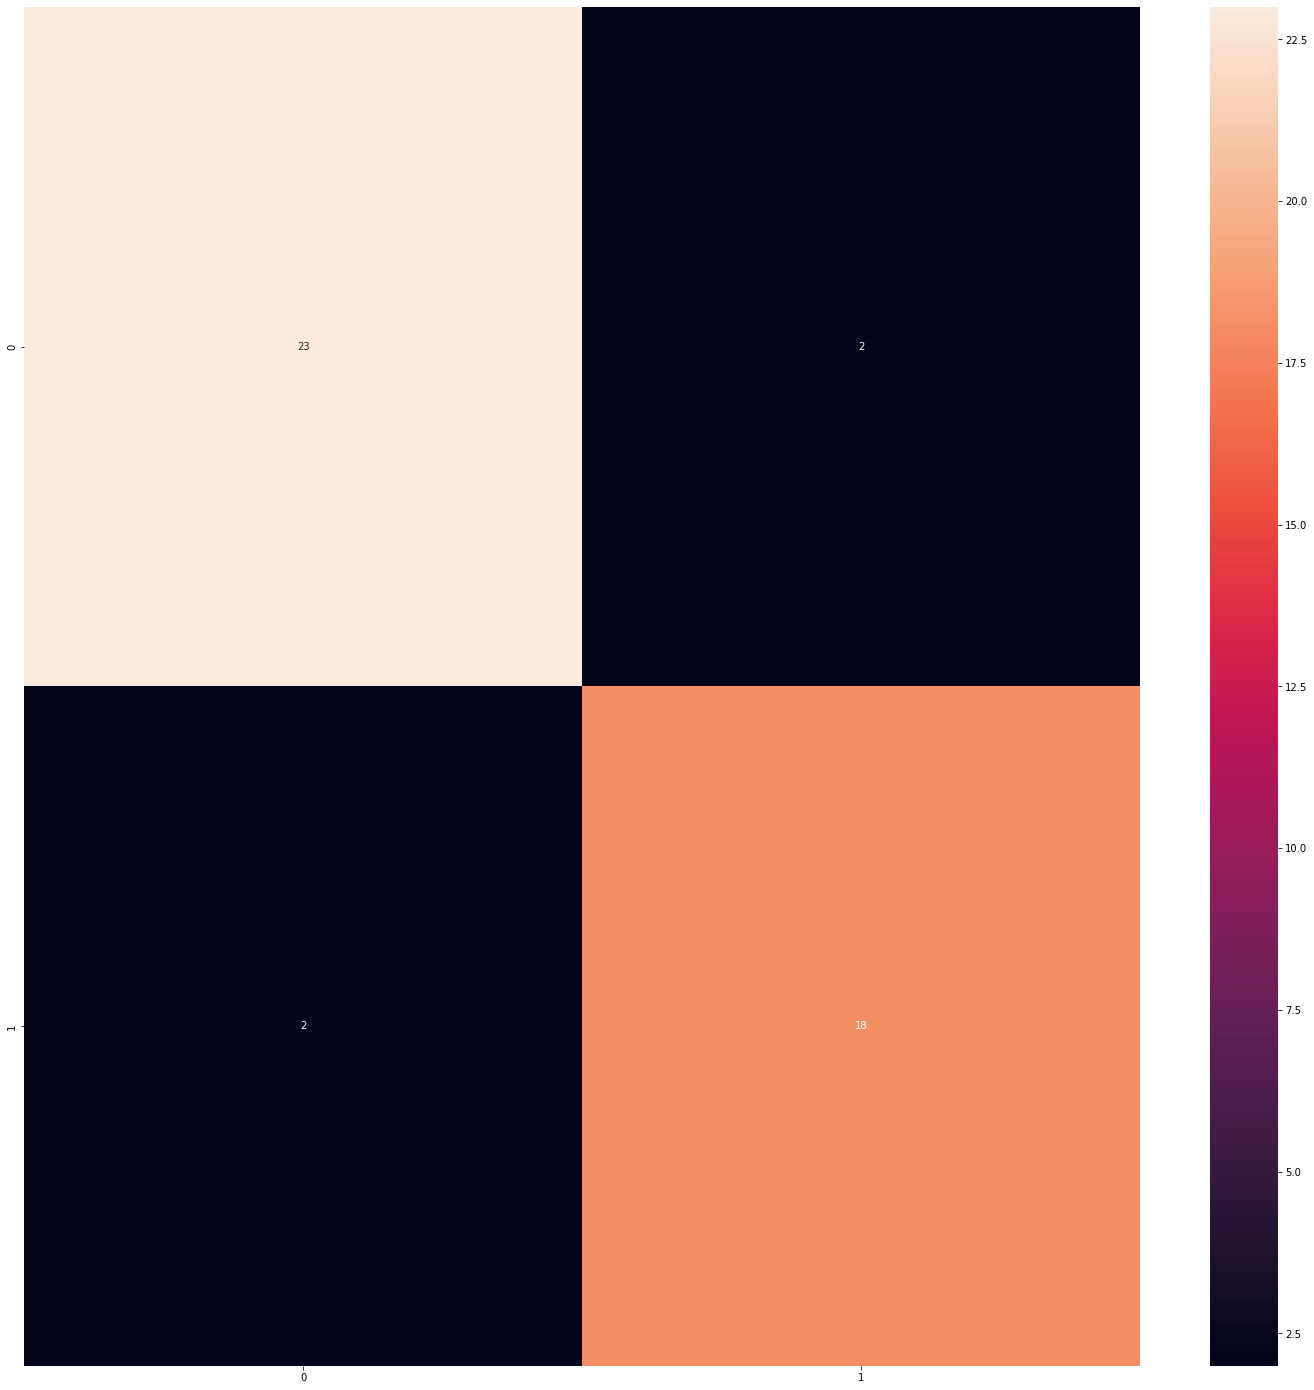

In [255]:
# get the confusion matrix
cm = confusion_matrix(list(y_val), prediction)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True)

In [256]:
# Check version for save the model
print(tf.__version__)

2.7.0


In [257]:
model.save_weights('./model/lstm_model/')

# Part 3: Logistic Regression - Deploy

In [258]:
# T√°ch t·∫≠p hu·∫•n luy·ªán v√† t·∫≠p validation theo t·ªâ l·ªá 7:3
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_sr, test_size=0.3, stratify=y_sr, random_state=100)

In [259]:
X_train.head()

188    ƒëi h·ªçc m·∫π th√°i_lan b·∫Øt nh·∫∑t r√°c . asia_one 22/...
7      h·∫°i n√£o v·ªçng_c·ªï vu√¥ng_tr√≤n tam_gi√°c . ch∆∞∆°ng_t...
219    th∆∞·ªüng 20.000 usd ƒë·ªôi_tuy·ªÉn c·ªù_vua vi·ªát_nam ol...
189    √¥t√¥ ƒëi ng∆∞·ª£c chi·ªÅu ph·∫°t 800.000 ƒë·ªìng . kho·∫£n l...
23     bi_k·ªãch ngo·∫°i_t√¨nh b·ªë ch·ªìng . th√†nh ‚Äú ƒë√†n_b√† ‚Äù...
Name: clean_joined, dtype: object

In [260]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), lowercase=True, max_features=5000)
X_train_transformed = tfidf.fit_transform(X_train)
X_test_transformed = tfidf.transform(X_test)

In [261]:
X_train_transformed.shape

(156, 5000)

In [262]:
lr = LogisticRegression()
lr.fit(X_train_transformed, y_train)

LogisticRegression()

In [263]:
y_pred = lr.predict(X_test_transformed)

In [264]:
# Get accuracy
result = accuracy_score(y_test, y_pred)
print("Accuracy : {}".format(result))

Accuracy : 0.8656716417910447


<AxesSubplot:>

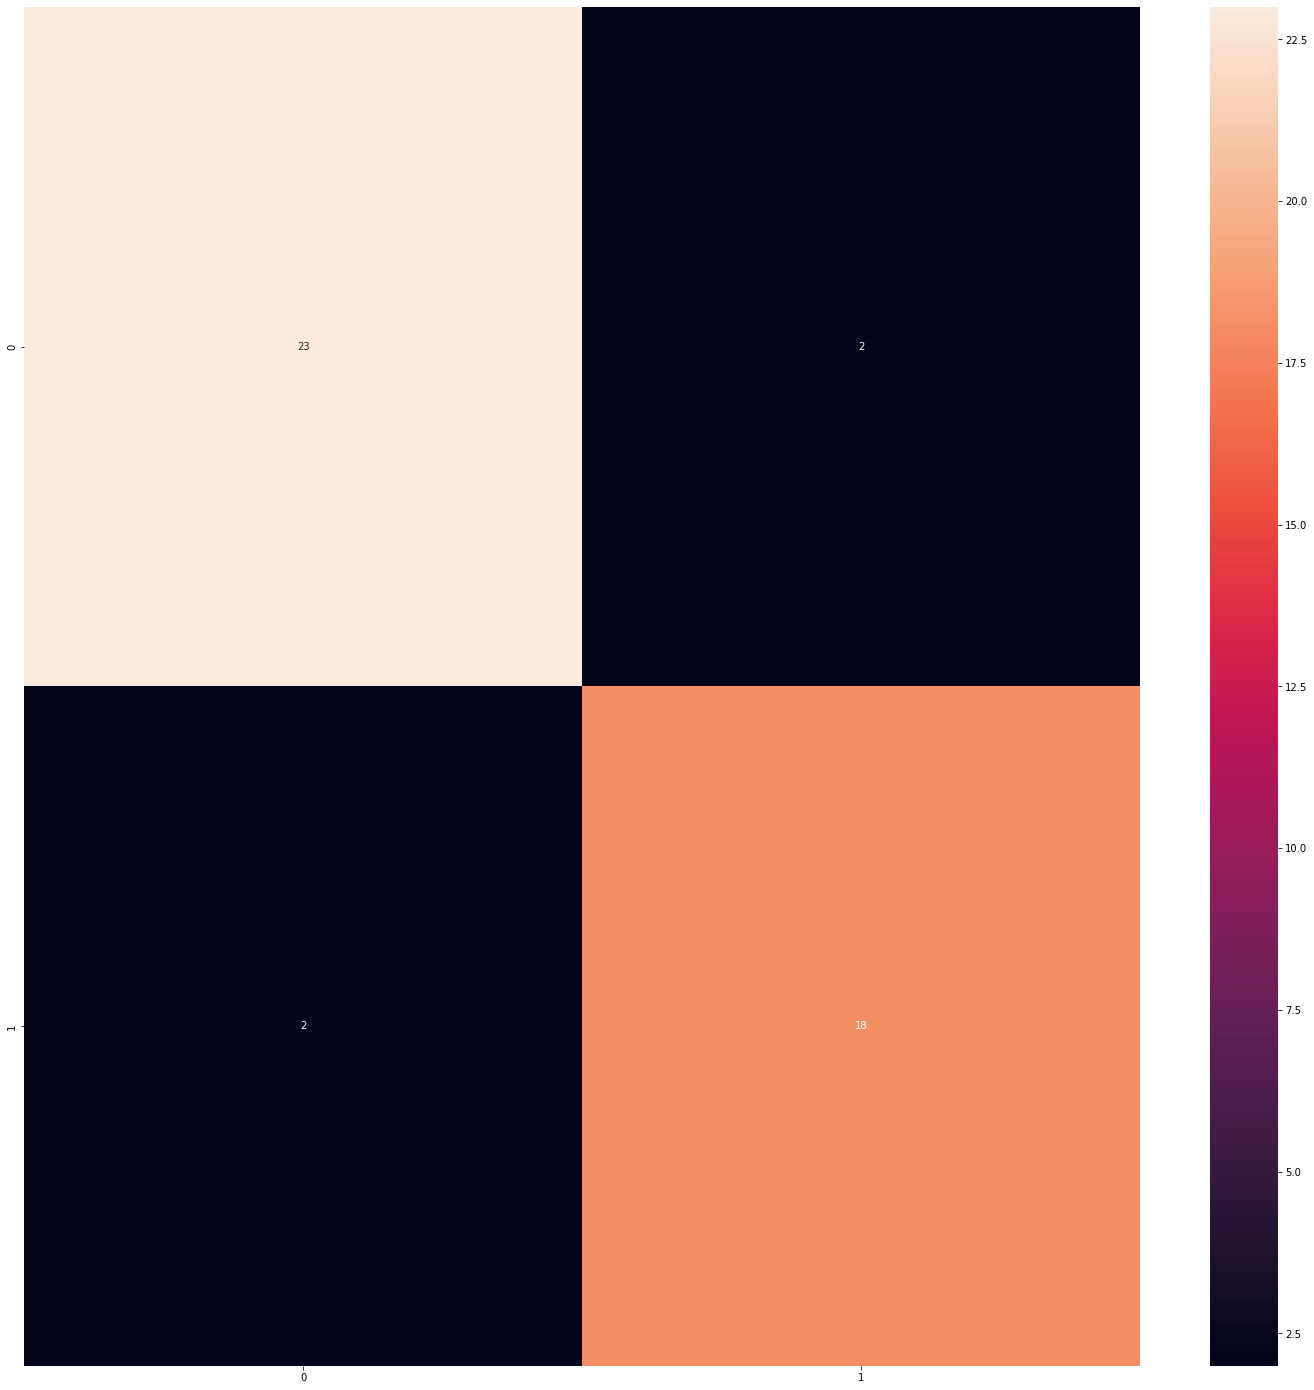

In [265]:
# get the confusion matrix
confusion_matrix(y_test, y_pred)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True)

In [266]:
# save model
with open('./model/lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)